# Python for Labs/Lectures

## Lecture 4: Fitting
Nicholas Lee-Hone

July 2019

We will be using the `curve_fit` function from `scipy.optimize` in this lecture to do nonlinear least squares fitting. Internally `curve_fit` uses the Levenberg-Marquardt algorithm to perform the optimization.

The following link provides more information on how the Levenberg-Marquardt algorithm works:
- http://www.brnt.eu/phd/node10.html#SECTION00622700000000000000

There is a much more sophisticated package called `lmfit` that allows for constraints between parameters, custom residual functions, and that automatically returns much more information about the fit such as the errors on the parameters and chisqr. Despite being a better package, it is more complex to set up and would probably be less suitable for a teaching environment.

## Fitting procedure
- Load the data and plot it
- Define the model function
- Plot the model function on top of the data
    - Explore model parameters until the model is close to the data
- Run the fit algorithm and plot the results
- Interpret the results of the fit

### Load the data and plot it

In [1]:
# Import packages
# Numpy for loading data and creating arrays
import numpy as np
# Matplotlib for plotting
import matplotlib.pyplot as plt
# Alias scipy as sp
import scipy as sp
# scipy.optimize for the curve_fit function
import scipy.optimize

Despite the data having uncertainties we will start by fitting to the data as if it does not have any uncertainty. We will then explore what changes when the uncertainties are specified.

(0, 231.25)

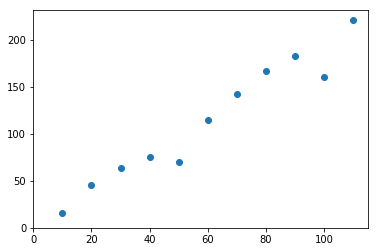

In [3]:
# Read the data from the csv file. There is a header in the first line so skip it
x_data, y_data, y_err = np.genfromtxt('Example-Data.csv', delimiter=',', unpack=True, skip_header=1)

# Plot the data
plt.plot(x_data, y_data, 'o')
plt.xlim(xmin=0)
plt.ylim(ymin=0)

### Define the model function

In [4]:
# The model function always takes the independent variable as its first parameter, 
# and the parameters that will be optimized come after.
def model(x, m, b):
    return m*x + b

### Plot the model function

(0, 254.10000000000002)

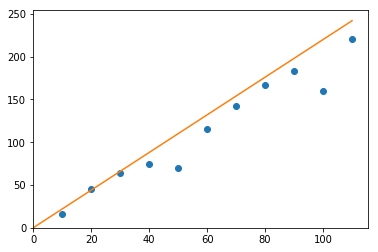

In [5]:
# Points at which we will evaluate the model function
x = np.linspace(0, max(x_data), 100)

# Choose some initial guesses for the parameters
m_init = 2.2
b_init = 0

plt.plot(x_data, y_data, 'o')
# Plot the model using the initial parameter guesses
plt.plot(x, model(x, m_init, b_init))
plt.xlim(xmin=0)
plt.ylim(ymin=0)

### Run the fitting procedure and plot the results

`curve_fit` returns a tuple of values: pOpt, and pCov.

pOpt is an array containing the optimized parameter values.

pCov is the covariance matrix of pOpt.

(0, 232.0536363645872)

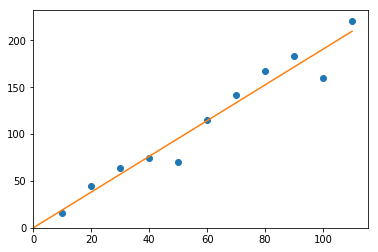

In [7]:
pOpt1, pCov1 = sp.optimize.curve_fit(model, x_data, y_data, p0=(m_init, b_init))

plt.plot(x_data, y_data, 'o')
plt.plot(x, model(x, pOpt1[0], pOpt1[1]))
plt.xlim(xmin=0)
plt.ylim(ymin=0)

(0, 232.0536363645872)

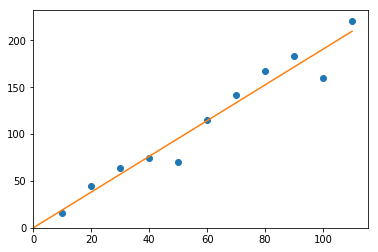

In [8]:
pOpt1, pCov1 = sp.optimize.curve_fit(model, x_data, y_data, p0=(m_init, b_init))

plt.plot(x_data, y_data, 'o')
plt.plot(x, model(x, *pOpt1))  # Use parameter expansion to fill the correct places
plt.xlim(xmin=0)
plt.ylim(ymin=0)

### Interpret the fit results

The uncertainty in a parameter $a_j$ is $\alpha_j=\sqrt{C_{jj}}$.

In [10]:
# Reshape is used make the errors into a 1xN array to help build the correlation matrix
errs1 = np.sqrt(pCov1.diagonal()).reshape((1, -1))
errs1

array([[ 0.14994813, 10.16998612]])

The correlation between two parameters is $$\rho_{ij}=\frac{C_{ij}}{\sqrt{C_{ii}C_{jj}}}$$

In [11]:
corr1 = pCov1/(errs1.T@errs1)
corr1

array([[ 1.        , -0.88465152],
       [-0.88465152,  1.        ]])

Show the correlation matrix as an image. For two parameters this is overkill, but it can be useful if you have many parameters in the fit.

([<matplotlib.axis.XTick at 0x7f64f65f0cf8>,
 <a list of 2 Text xticklabel objects>)

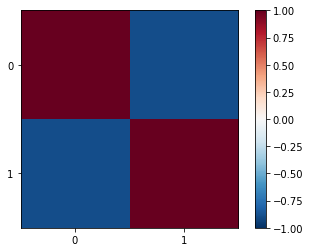

In [13]:
# Set the range of values to be between -1 and 1 with vmin and vmax
# Use a divergent colour map to represent the values. 
# 'RdBu' is a red to blue divergent color map. 
# Putting '_r' at the end reverses the color map order so it goes from blue to red instead.
plt.imshow(corr1, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar()
plt.yticks([0, 1])
plt.xticks([0, 1])  

## Including uncertainties in the fit

The first step in including the uncertainties is to set `sigma=y_err`. This assigs a weight $w_i=\frac{1}{\sigma_i^2}$ to residual $r_i$ in the nonlinear least squares fitting procedure.

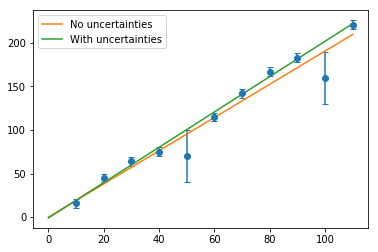

In [14]:
# absolute_sigma=False by default
pOpt2, pCov2 = sp.optimize.curve_fit(model, x_data, y_data, p0=(m_init, b_init), sigma=y_err)

plt.errorbar(x_data, y_data, yerr=y_err, fmt='o', capsize=3)
plt.plot(x, model(x, *pOpt1), label='No uncertainties')
plt.plot(x, model(x, *pOpt2), label='With uncertainties')
plt.legend()

In [15]:
errs2 = np.sqrt(pCov2.diagonal()).reshape((1, -1))
errs2

array([[0.05231192, 3.40859664]])

In [16]:
corr2 = pCov2/(errs2.T@errs2)
corr2

array([[ 1.        , -0.87139259],
       [-0.87139259,  1.        ]])

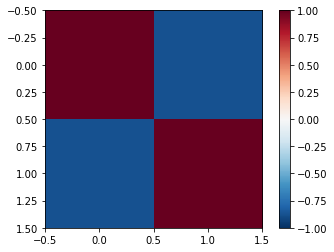

In [17]:
plt.imshow(corr2, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar()

In the previous iteration of the `curve_fit` the parameter `absolute_sigma` was set to `False` by default. This means that the sigma values are scaled so that the reduced chi^2 for the optimized fit parameters is 1. This would be used when we don't know the exact value of the uncertainty, but know the relative weights assigned to each point.

In order to tell curve_fit that it should consider the scale of the uncertainties to be known we have to set `absolute_sigma=True` in the `curve_fit` parameters. The values of sigma are then not scaled, and the reduced chi^2 is not forced to be 1. This would be used when we know the actual uncertainty, as is typically the case in physics experiments.

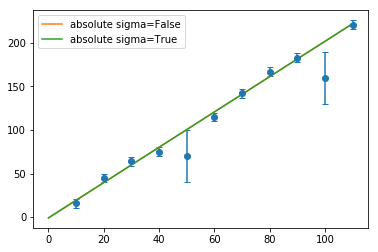

In [18]:
# Set absolute_sigma=True to specify measured uncertainties
pOpt3, pCov3 = sp.optimize.curve_fit(model, x_data, y_data, p0=(m_init, b_init), sigma=y_err, absolute_sigma=True)

plt.errorbar(x_data, y_data, yerr=y_err, fmt='o', capsize=3)
plt.plot(x, model(x, *pOpt2), label='absolute sigma=False')
plt.plot(x, model(x, *pOpt3), label='absolute sigma=True')
plt.legend()

In [21]:
errs3 = np.sqrt(pCov3.diagonal()).reshape((1, -1))
errs3

array([[0.0519783 , 3.38685812]])

In [22]:
corr3 = pCov3/(errs3.T@errs3)
corr3

array([[ 1.        , -0.87139259],
       [-0.87139259,  1.        ]])

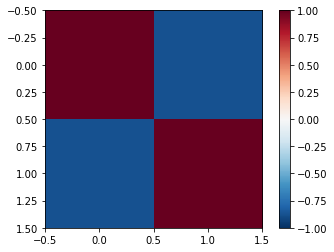

In [23]:
plt.imshow(corr3, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar()

In [25]:
# Add a scale parameter so we can rescale the uncertainties
scale = 1

# Fit with absolute_sigma=False
pOpt2, pCov2 = sp.optimize.curve_fit(model, x_data, y_data, 
                                     p0=(m_init, b_init), sigma=y_err*scale)

# Fit with absolute_sigma=True
pOpt3, pCov3 = sp.optimize.curve_fit(model, x_data, y_data, 
                                     p0=(m_init, b_init), sigma=y_err*scale, 
                                     absolute_sigma=True)

errs2 = np.sqrt(pCov2.diagonal()).reshape((1, -1))
errs3 = np.sqrt(pCov3.diagonal()).reshape((1, -1))

print('absolute_sigma=False:', errs2)
print()
print('absolute_sigma=True:', errs3)

absolute_sigma=False: [[0.05231192 3.40859664]]

absolute_sigma=True: [[0.0519783  3.38685812]]


## Importance of choosing initial parameters

Although algorithms like gradient descent and Levenberg-Marquardt are commonly referred to as fitting algorithms, this is a bit of a misnomer. These algorithms do not in fact fit to the data; they simply take an initial guess of the optimal parameters, and find some local minimum that is in some way reachable from this point.

A more apt name for fitting algorithms would be refinement algorithms, as they refine some initial guess that is close to the solution.

<ErrorbarContainer object of 3 artists>

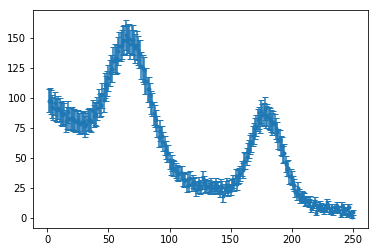

In [26]:
# Load and plot the data
# There are no uncertainties in the data, so we will assume the uncertainty is sqrt(y)
x_data, y_data = np.genfromtxt('Gauss1.csv', delimiter=',', unpack=True)
y_err = y_data**0.5
plt.errorbar(x_data, y_data, yerr=y_err, fmt='.', capsize=3)

# Comment the previous errorbar command and uncomment this one if you want to see every third point
#plt.errorbar(x_data[::3], y_data[::3], yerr=y_err[::3], fmt='.', capsize=3)

In [27]:
def model(x, B, tau, A1, mu1, sigma1, A2, mu2, sigma2):
    # Exponential decay and two gaussian peaks
    return B*np.exp(-x/tau) + A1*np.exp(-(x - mu1)**2/(2*sigma1**2)) + A2*np.exp(-(x - mu2)**2/(2*sigma2**2))

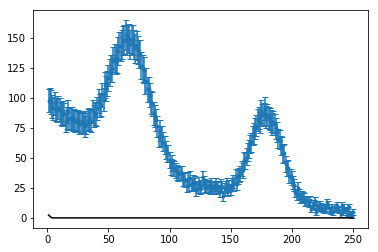

In [28]:
x = np.linspace(min(x_data), max(x_data), 100)

#   model(x,  B,  tau, A1, mu1, sigma1, A2, mu2, sigma2)  # Reminder of parameter order
y = model(x,  1,   1,  1,   1,     1,   1,   1,   1)  # Bad initial parameter estimate

plt.errorbar(x_data, y_data, yerr=y_err, fmt='.', capsize=3)
plt.plot(x, y, zorder=10, c='k') 

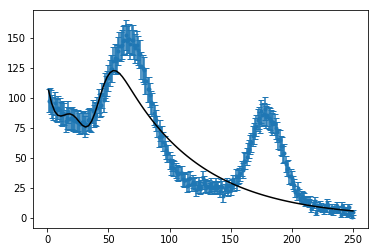

In [29]:
pOpt, pCov = sp.optimize.curve_fit(model, x_data, y_data, p0=(1, 1, 1, 1, 1, 1, 1, 1),
                                  sigma=y_err, absolute_sigma=True)

plt.errorbar(x_data, y_data, yerr=y_err, fmt='.', capsize=3)
plt.plot(x, model(x, *pOpt), zorder=10, c='k')

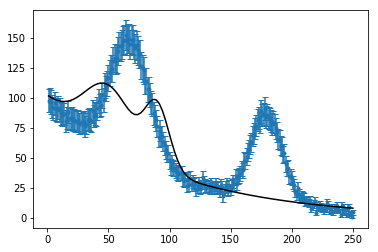

In [30]:
x = np.linspace(min(x_data), max(x_data), 100)

#   model(x,  B,  tau, A1, mu1, sigma1, A2, mu2, sigma2)  # Reminder of parameter order
y = model(x, 100, 100, 50,  50,   20,   50, 90,   10)  # Bad initial parameter estimate

plt.errorbar(x_data, y_data, yerr=y_err, fmt='.', capsize=3)
plt.plot(x, y, zorder=10, c='k') 

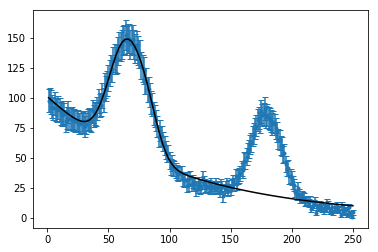

In [31]:
pOpt, pCov = sp.optimize.curve_fit(model, x_data, y_data, p0=(100, 100, 50, 50, 20, 50, 90, 10),
                                   sigma=y_err, absolute_sigma=True)

plt.errorbar(x_data, y_data, yerr=y_err, fmt='.', capsize=3)
plt.plot(x, model(x, *pOpt), c='k', zorder=10)

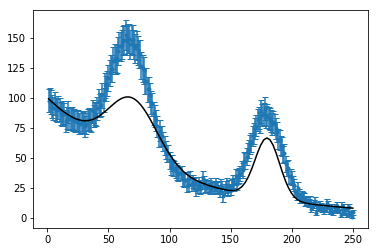

In [33]:
x = np.linspace(min(x_data), max(x_data), 100)

#   model(x,  B,  tau, A1, mu1, sigma1, A2, mu2, sigma2)  # Reminder of parameter order
y = model(x, 100, 100, 50,  70,   20,   50, 180,   10)  # OK initial parameter estimate

plt.errorbar(x_data, y_data, yerr=y_err, fmt='.', capsize=3)
plt.plot(x, y, zorder=10, c='k') 

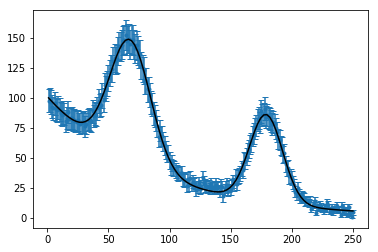

In [34]:
pOpt, pCov = sp.optimize.curve_fit(model, x_data, y_data, p0=(100, 100, 50, 70, 20, 50, 180, 10),
                                  sigma=y_err, absolute_sigma=True)

plt.errorbar(x_data, y_data, yerr=y_err, fmt='.', capsize=3)
plt.plot(x, model(x, *pOpt), zorder=10, c='k')

### Interpret the results

[[2.28336148 1.90423487 2.60528645 0.44348863 0.45751866 2.1233286
  0.36412952 0.35871676]]


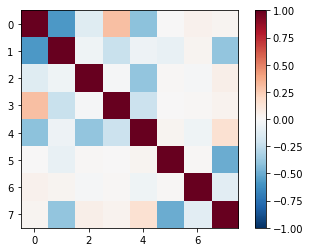

In [35]:
# Visualizing the covariance matrix
errs = np.sqrt(pCov.diagonal()).reshape((1, -1))
corr = pCov/(errs.T@errs)

print(errs)

plt.imshow(corr, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar()

#   model(x,  B,  tau, A1, mu1, sigma1, A2, mu2, sigma2)  # Reminder of parameter order
#             0,   1,   2,  3,    4,     5,  6,     7

## Plot fit and residuals

In [36]:
# subplot2grid is similar to subplot, but allows more customization
# 
# subplot2grid((3, 1), (0, 0), rowspan=2)
# First create a 3x1 grid with the following indices
# [[0,0]
#  [1,0]
#  [2,0]]
#
# Place the current axes in cell (0, 0) and let it span 2 rows

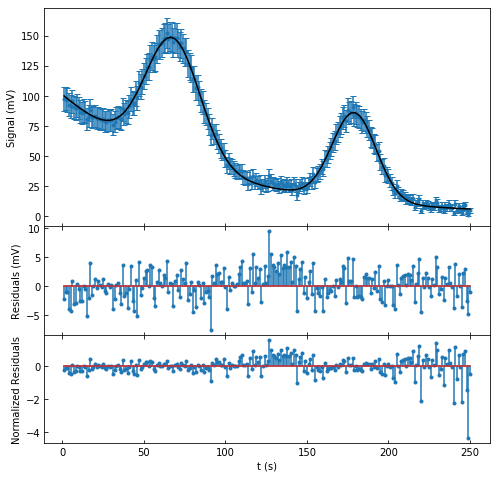

In [37]:
fig = plt.figure(figsize=(8, 8))
plt.subplot2grid((4, 1), (0, 0), rowspan=2)
plt.errorbar(x_data, y_data, yerr=y_err, fmt='.', capsize=3)
plt.plot(x, model(x, *pOpt), zorder=10, c='k')
plt.ylabel('Signal (mV)')
ax = plt.gca()
ax.set_xticklabels([])
plt.tick_params(direction='in')

plt.subplot2grid((4, 1), (2, 0))
plt.stem(x_data, y_data - model(x_data, *pOpt), markerfmt='.')
plt.tick_params(direction='in', top=True)
plt.ylabel('Residuals (mV)')
ax = plt.gca()
ax.set_xticklabels([])
plt.tick_params(direction='in')

plt.subplot2grid((4, 1), (3, 0))
plt.stem(x_data, (y_data - model(x_data, *pOpt))/y_err, markerfmt='.')
plt.tick_params(direction='in', top=True)
plt.ylabel('Normalized Residuals')
plt.xlabel('t (s)')

plt.subplots_adjust(hspace=0)

In [ ]:
fig

## Small or large parameters